In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
 
#from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import regularizers
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.style as sty

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

import os
import random as rn
import seaborn as sns

import tensorflow as tf
import cv2


In [10]:
#Configurações Arbritarias escolhidas para treinamento
batch_size = 64
num_classes = 10
epochs = 50
W=64
H=64


In [16]:
# load train and test dataset (CIFAR 10)
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # pegando apenas parte das imagens de treinamento devido ao limite de nossa memória
    #Xtr, Xvl, ytr, yvl = train_test_split(trainX, trainY, test_size=.0,random_state=42,stratify=trainY)
    Xtr=trainX
    ytr=trainY
    # one hot encode target values
    nb_train_samples = len(Xtr)
    nb_test_samples = len(testX)
    print(nb_train_samples)
    trainX = np.array([cv2.resize(img, (W,H)) for img in Xtr[:nb_train_samples,:,:,:]])
    testX = np.array([cv2.resize(img, (W,H)) for img in testX[:nb_test_samples,:,:,:]])
    trainY = to_categorical(ytr)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [17]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [18]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
print(trainX.shape)
print(testX.shape)
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

50000
(50000, 64, 64, 3)
(10000, 64, 64, 3)


In [32]:
#Inserir estrutura da CNN nessa parte do codigo
model=Sequential()

model.add(Conv2D(28, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=trainX.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(28, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 28)        784       
                                                                 
 activation_12 (Activation)  (None, 64, 64, 28)        0         
                                                                 
 batch_normalization_12 (Bat  (None, 64, 64, 28)       112       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 28)        7084      
                                                                 
 activation_13 (Activation)  (None, 64, 64, 28)        0         
                                                                 
 batch_normalization_13 (Bat  (None, 64, 64, 28)       112       
 chNormalization)                                     

In [33]:
# Compilar a CNN
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'] )


In [ ]:
# Imprimir a topologia
model.summary()

In [34]:
# Treinar a CNN
#es=EarlyStopping(monitor='val_loss', mode='min', verbose=1)

fp='/content/checkpoints/bestmodel.hdf5'
#fp='/content/checkpoints/cp-{epoch:02d}.hdf5'
mc = tf.keras.callbacks.ModelCheckpoint(
#    filepath='/content/checkpoints/cp-{epoch:02d}.hdf5',
    filepath=fp,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
results=model.fit(trainX, trainY,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_split=0.2,
                  callbacks=[mc])

# Os pesos do melhor modelo são carregados
model.load_weights(fp)

Epoch 1/50
624/625 [============================>.] - ETA: 0s - loss: 1.7802 - accuracy: 0.4382
Epoch 00001: val_accuracy improved from -inf to 0.32600, saving model to /content/checkpoints/bestmodel.hdf5
625/625 [==============================] - 20s 30ms/step - loss: 1.7792 - accuracy: 0.4383 - val_loss: 2.2763 - val_accuracy: 0.3260
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 1.1372 - accuracy: 0.6090
Epoch 00002: val_accuracy improved from 0.32600 to 0.58840, saving model to /content/checkpoints/bestmodel.hdf5
625/625 [==============================] - 18s 30ms/step - loss: 1.1372 - accuracy: 0.6090 - val_loss: 1.2612 - val_accuracy: 0.5884
Epoch 3/50
625/625 [==============================] - ETA: 0s - loss: 0.8913 - accuracy: 0.7012
Epoch 00003: val_accuracy improved from 0.58840 to 0.66350, saving model to /content/checkpoints/bestmodel.hdf5
625/625 [==============================] - 18s 30ms/step - loss: 0.8913 - accuracy: 0.7012 - val_loss: 1.0133 - v

In [1]:
# Executar a avaliação (teste)
score=model.evaluate(testX, testY, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

NameError: ignored

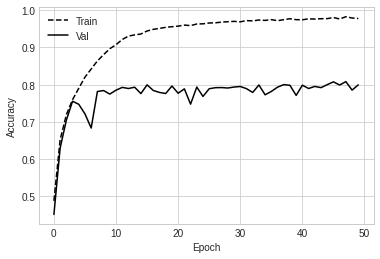

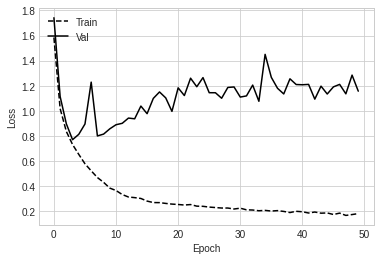

In [25]:
# Plotar o grafico do histórico de evolução do treinamento
sty.use('seaborn-whitegrid')
plt.plot(results.history['accuracy'],'k--')
plt.plot(results.history['val_accuracy'],'k')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plota o grafico do histórico de evolução da taxa de perda da rede 
plt.plot(results.history['loss'],'k--')
plt.plot(results.history['val_loss'],'k')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [26]:
# Plotar a matrix de confusão 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  
  print(cm)
  
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")
   
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [27]:
# Predição da CNN
y_predict=np.argmax(model.predict(testX), axis=1)

# Preparar Matriz de Confusão
cm=confusion_matrix(np.argmax(testY, axis=1), y_predict)

Confusion matrix, without normalization
[[838   8  47  11  11   7  10  12  34  22]
 [ 12 910   5   3   6   3   2   3   8  48]
 [ 58   2 692  49  68  61  47  19   3   1]
 [ 17   4  69 573  41 194  51  35  12   4]
 [ 11   2  53  42 763  35  36  52   6   0]
 [ 10   2  44 128  31 734  11  35   4   1]
 [  6   2  37  38  24  29 853   7   3   1]
 [  4   1  23  22  44  44   6 854   0   2]
 [ 51  14  13   7   8   5  10   6 863  23]
 [ 18  55   8  12   5   6   2  16  18 860]]


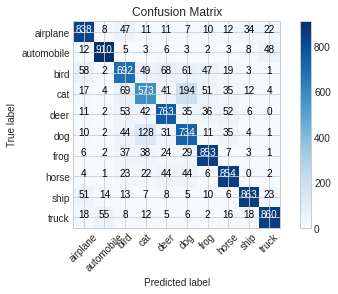

In [28]:
# Chamada da matriz confusão
cm_plot_labels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cm, cm_plot_labels, title= 'Confusion Matrix')


In [29]:
# Salvando o modelo, a arquitetura da CNN
model_json = model.to_json()
with open("cnn.json", "w") as json_file:
  json_file.write(model_json)

# Salvando os pesos da CNN
model.save_weights("cnn_weights.h5")

In [30]:
# Exemplo de como carregar a usar modelo salvo.

from keras.models import model_from_json

# Carregando o modelo
json_file=open("cnn.json", "r")
cnn_json=json_file.read()
json_file.close()

cnn_model=model_from_json(cnn_json)

# Carregando os pesos
cnn_model.load_weights("cnn_weights.h5")

# Predição usando o modelo carregado
y_predict=np.argmax(cnn_model.predict(testX), axis=1)

y=np.argmax(testY, axis=1)

# Predição usando apenas uma imagem
exemplo=testX[2]
print(exemplo.shape)
exemplo = exemplo.reshape(1, W, H, 3)
saida=cnn_model.predict(exemplo)
classe=np.argmax(saida, axis=1)

y_test=np.argmax(testY[2], axis=0)
print(cm_plot_labels[classe[0]], 'expected:', cm_plot_labels[y_test] )


(64, 64, 3)
ship expected: ship


Classe predita: [3] rótulo: 0 Score:  0.7694065


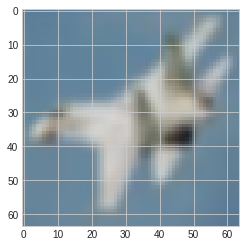

Classe predita: [2] rótulo: 0 Score:  0.77207375


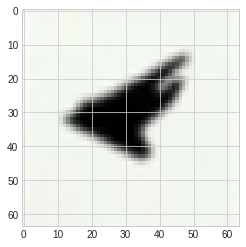

Classe predita: [4] rótulo: 5 Score:  0.9270942


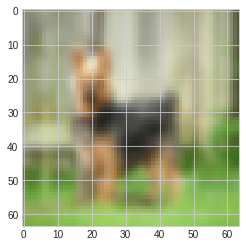

Classe predita: [3] rótulo: 2 Score:  0.99296725


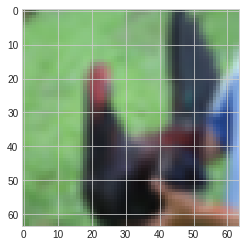

Classe predita: [5] rótulo: 4 Score:  0.9808023


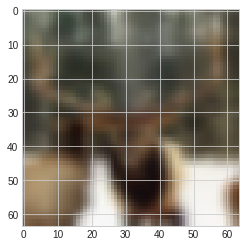

Classe predita: [3] rótulo: 2 Score:  0.96663386


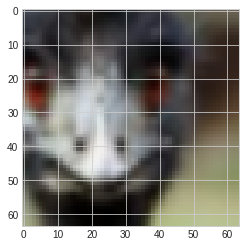

Classe predita: [3] rótulo: 5 Score:  0.887969


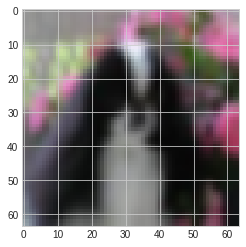

Classe predita: [4] rótulo: 3 Score:  0.6282169


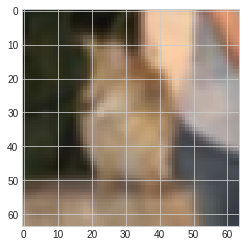

Classe predita: [3] rótulo: 0 Score:  0.95760685


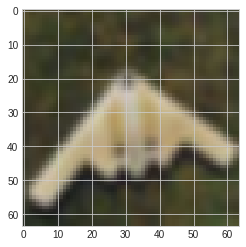

Classe predita: [3] rótulo: 4 Score:  0.599802


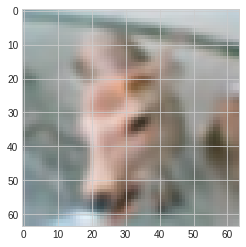

Classe predita: [3] rótulo: 6 Score:  0.66204363


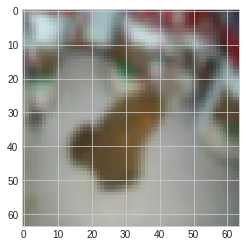

Classe predita: [5] rótulo: 3 Score:  0.9999976


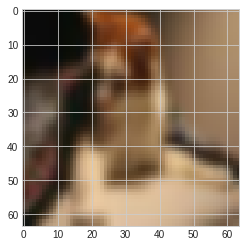

Classe predita: [8] rótulo: 1 Score:  0.5277798


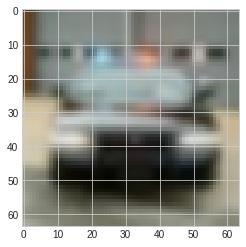

Classe predita: [5] rótulo: 3 Score:  0.9493131


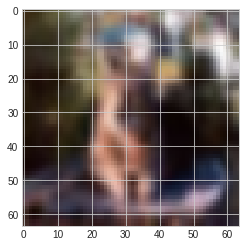

Classe predita: [7] rótulo: 9 Score:  0.9990471


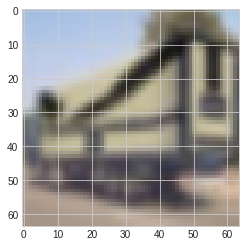

Classe predita: [5] rótulo: 3 Score:  0.9433198


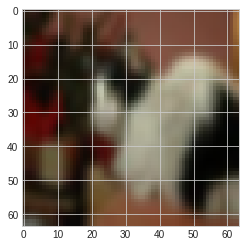

Classe predita: [4] rótulo: 7 Score:  0.7362907


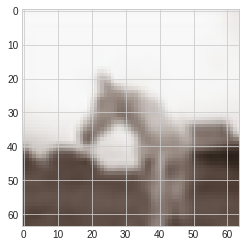

Classe predita: [6] rótulo: 3 Score:  0.5123398


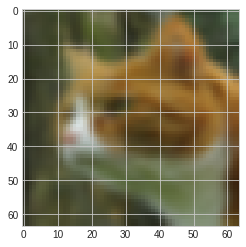

Classe predita: [6] rótulo: 3 Score:  0.95067006


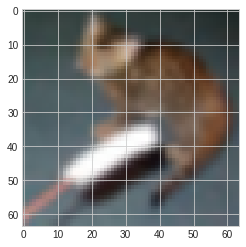

Classe predita: [2] rótulo: 6 Score:  0.548941


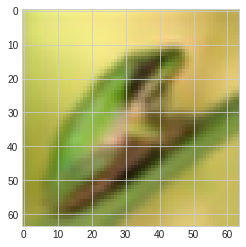

Classe predita: [2] rótulo: 3 Score:  0.39702088


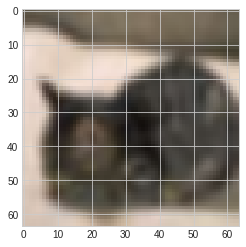

Classe predita: [6] rótulo: 2 Score:  0.4808994


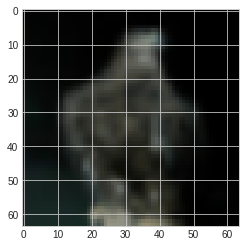

Classe predita: [6] rótulo: 0 Score:  0.6357327


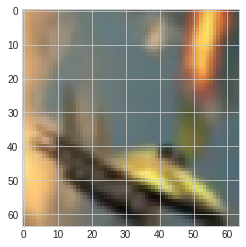

Classe predita: [3] rótulo: 5 Score:  0.7313663


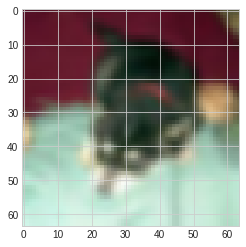

Classe predita: [8] rótulo: 9 Score:  0.973081


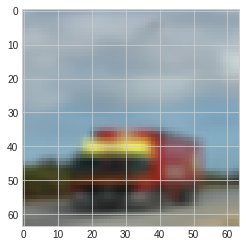

Classe predita: [5] rótulo: 3 Score:  0.9839013


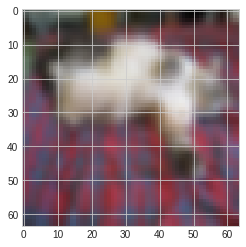

Classe predita: [2] rótulo: 7 Score:  0.956213


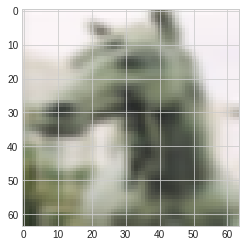

Classe predita: [5] rótulo: 2 Score:  0.99962485


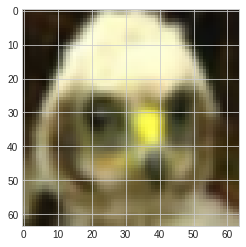

Classe predita: [0] rótulo: 8 Score:  0.5745774


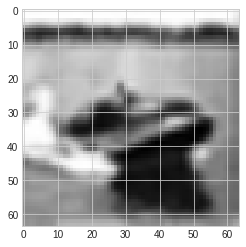

Classe predita: [3] rótulo: 5 Score:  0.94295937


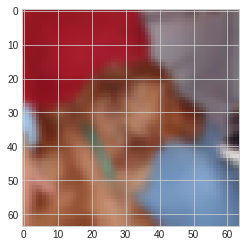

Classe predita: [5] rótulo: 6 Score:  0.9166637


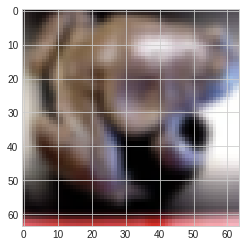

Classe predita: [0] rótulo: 8 Score:  0.6227482


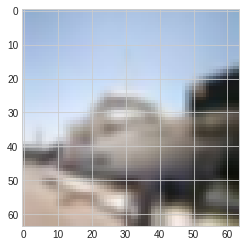

Classe predita: [0] rótulo: 9 Score:  0.99935347


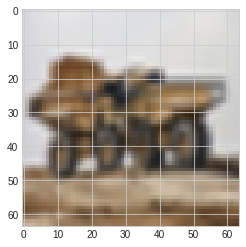

Classe predita: [0] rótulo: 3 Score:  0.93330836


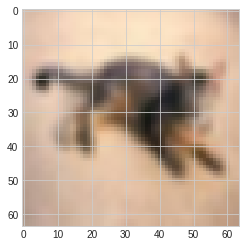

Classe predita: [2] rótulo: 6 Score:  0.68485457


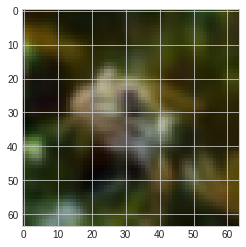

Classe predita: [7] rótulo: 4 Score:  0.9404635


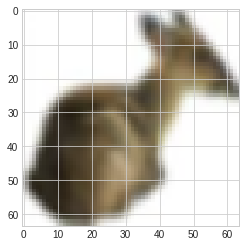

Classe predita: [8] rótulo: 0 Score:  0.8795098


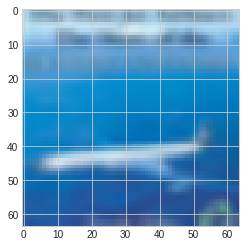

Classe predita: [9] rótulo: 0 Score:  0.73891145


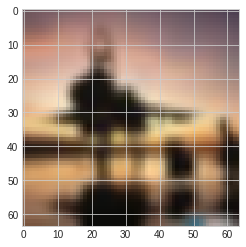

Classe predita: [3] rótulo: 4 Score:  0.66809714


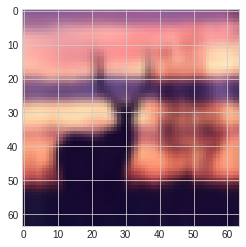

Classe predita: [7] rótulo: 9 Score:  0.6568295


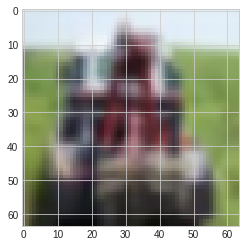

Classe predita: [4] rótulo: 2 Score:  0.98230493


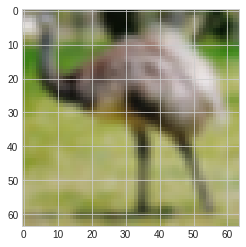

Classe predita: [3] rótulo: 6 Score:  0.4688041


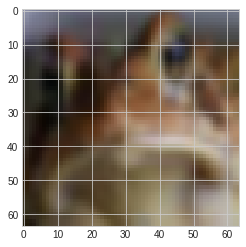

Classe predita: [3] rótulo: 6 Score:  0.8138218


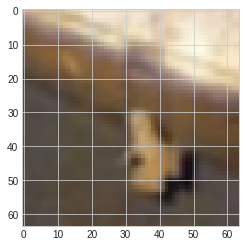

Classe predita: [7] rótulo: 0 Score:  0.69851124


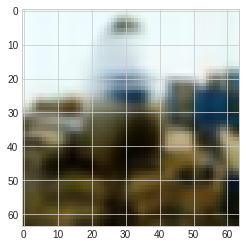

Classe predita: [8] rótulo: 3 Score:  0.8799784


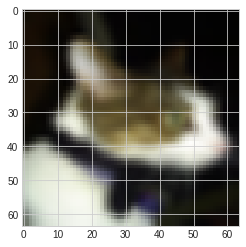

Classe predita: [8] rótulo: 9 Score:  0.9999764


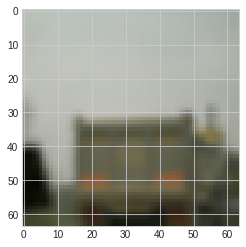

Classe predita: [4] rótulo: 2 Score:  0.59981066


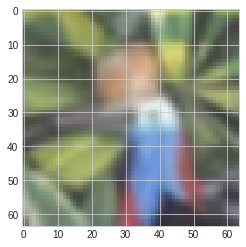

Classe predita: [6] rótulo: 8 Score:  0.94989777


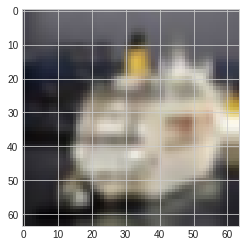

Classe predita: [8] rótulo: 5 Score:  0.7893043


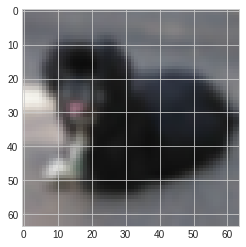

Classe predita: [5] rótulo: 3 Score:  0.86322355


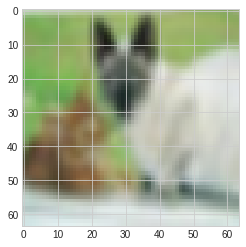

Classe predita: [7] rótulo: 5 Score:  0.46466652


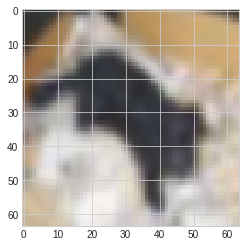

Classe predita: [7] rótulo: 3 Score:  0.81385946


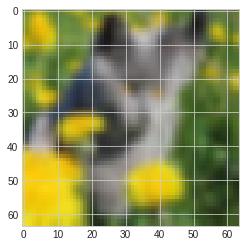

Classe predita: [8] rótulo: 0 Score:  0.9959066


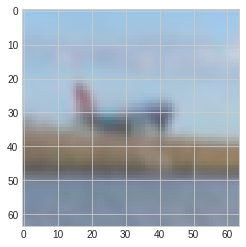

Classe predita: [2] rótulo: 4 Score:  0.90656203


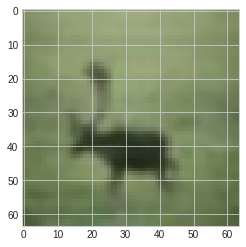

Classe predita: [9] rótulo: 1 Score:  0.64691955


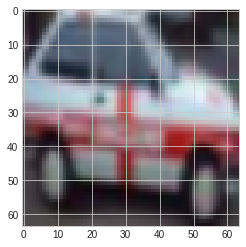

Classe predita: [0] rótulo: 8 Score:  0.9395627


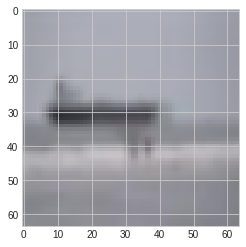

Classe predita: [3] rótulo: 5 Score:  0.9991775


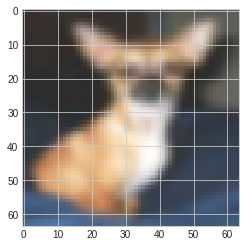

Classe predita: [7] rótulo: 4 Score:  0.98032975


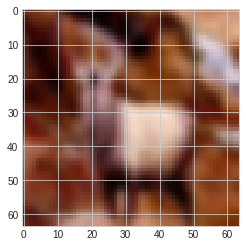

Classe predita: [6] rótulo: 3 Score:  0.637589


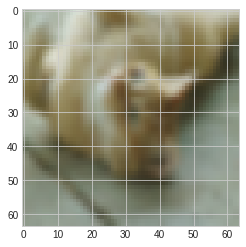

Classe predita: [3] rótulo: 5 Score:  0.47663286


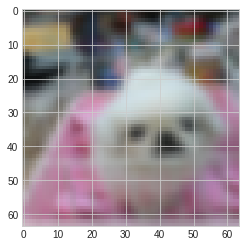

Classe predita: [0] rótulo: 8 Score:  0.93336296


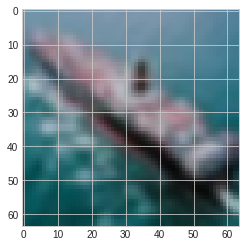

Classe predita: [3] rótulo: 5 Score:  0.8224421


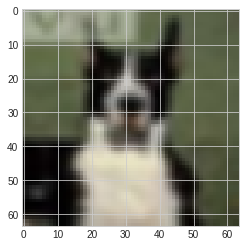

Classe predita: [7] rótulo: 4 Score:  0.91538906


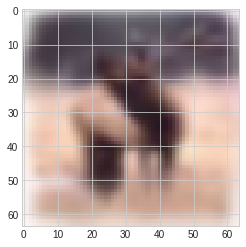

Classe predita: [3] rótulo: 2 Score:  0.7636837


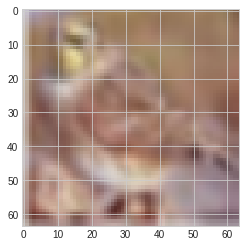

Classe predita: [4] rótulo: 7 Score:  0.99403435


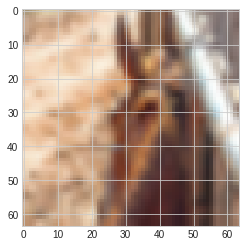

Classe predita: [5] rótulo: 3 Score:  0.9558773


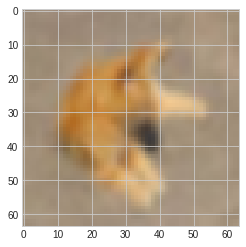

Classe predita: [9] rótulo: 1 Score:  0.4356595


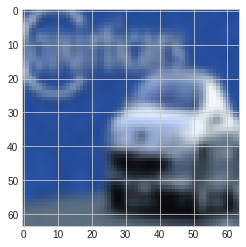

Classe predita: [2] rótulo: 4 Score:  0.95373243


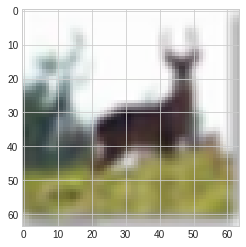

Classe predita: [2] rótulo: 3 Score:  0.7827864


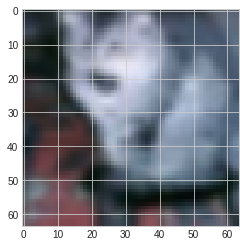

Classe predita: [2] rótulo: 8 Score:  0.77457064


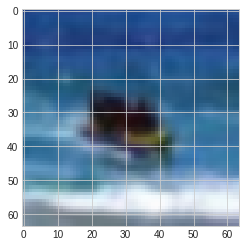

Classe predita: [2] rótulo: 4 Score:  0.9988471


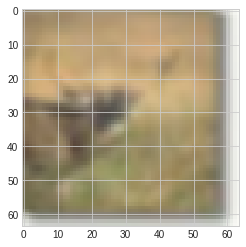

Classe predita: [9] rótulo: 0 Score:  0.96594375


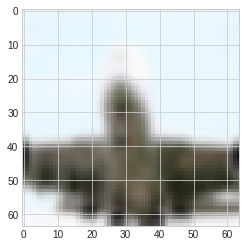

Classe predita: [4] rótulo: 7 Score:  0.51946896


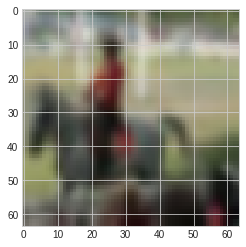

Classe predita: [2] rótulo: 0 Score:  0.9911945


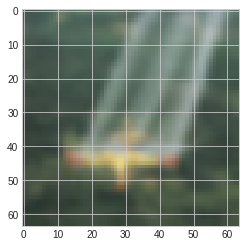

Classe predita: [5] rótulo: 2 Score:  0.99165815


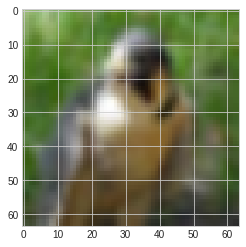

Classe predita: [5] rótulo: 2 Score:  0.8867025


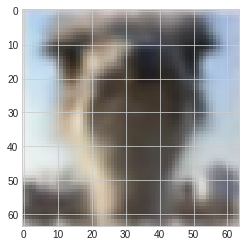

Classe predita: [6] rótulo: 2 Score:  0.8875273


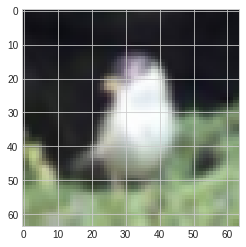

Classe predita: [5] rótulo: 3 Score:  0.9107184


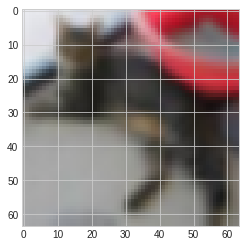

Classe predita: [6] rótulo: 3 Score:  0.6100433


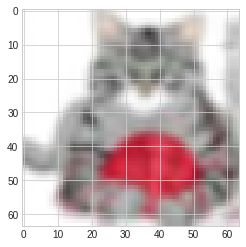

Classe predita: [5] rótulo: 3 Score:  0.60353917


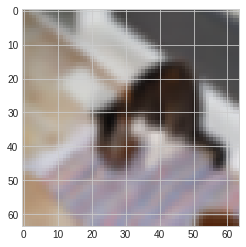

Classe predita: [3] rótulo: 0 Score:  0.98753846


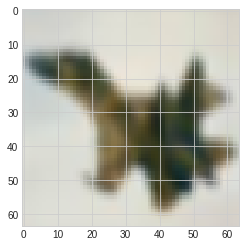

Classe predita: [5] rótulo: 7 Score:  0.5245568


KeyboardInterrupt: ignored

In [31]:
# Plotando os erros do modelo carregado
from matplotlib import pyplot as plt

rotulos=np.argmax(testY, axis=1)

for i in range(len(testX)):
  exemplo=testX[i]
  exemplo = exemplo.reshape(1, W, H, 3)
  saida=cnn_model.predict(exemplo)
  classe=np.argmax(saida, axis=1)
  if (classe == rotulos[i]):
    continue
  print("Classe predita:", classe, "rótulo:", rotulos[i], "Score: ", np.max(saida))
  exemplo = exemplo.reshape(W, H, 3)
  plt.imshow(exemplo, interpolation='nearest')
  plt.show()

